### Machine Learning for Bioinformatics (IBI5031) project - Group 5
#### Classification of ADHD and ASD comorbidities using machine learning methods.
#### Students - Cleiton Figueiredo, Marcelo Batista, Vanessa Gamero.
------------------------------------------
This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---------------

### Imports section

In [1]:
!pip install sklearn
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import learning_curve
!pip install scipy
from scipy import stats
from scipy.special import logit, expit
from scipy.stats.contingency import expected_freq
import statsmodels.api as sm
import scipy.special
!pip install plotly
!pip install cufflinks
import plotly.figure_factory as ff
import plotly.graph_objs as go
!pip install pandas
from pandas.plotting import scatter_matrix
import pandas as pd
!pip install seaborn
import seaborn as sns
!pip install numpy
import numpy as np
import scipy.stats as ss
!pip install matplotlib
from matplotlib.ticker import AutoMinorLocator
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
!pip install yellowbrick
from yellowbrick.model_selection import FeatureImportances

### Summary <a class="anchor" id="topo"></a>

* [Data file import and and visualization](#part_00).
* [ASD data analysis](#part_01). 
* [Feature selection in ASD data](#part_02).
* [Creating models to assess ASD training and learning BEFORE removing less important features](#part_03).
* [Creating models to assess ASD training and learning AFTER removing less important features](#part_04).
* [ADHD data analysis](#part_05).
* [Feature selection in ADHD data](#part_06).
* [Creating models to assess ADHD training and learning BEFORE removing less important features](#part_07).
* [Creating models to assess ADHD training and learning AFTER removing less important features](#part_08).
* [Conclusions](#part_09)

----------------
### Data file import and and visualization <a class="anchor" id="part_00"></a>

In [2]:
with open('archive_for_discipline.txt', 'r') as d:
    df = pd.read_table(d, sep= ',')

C:\Users\T-Gamer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(5) # View of the first five lines

,Unnamed: 0,Chr,Start,End,Ref,Alt,Ref_Gene,Func_refGene,ExonicFunc_refGene,avsnp147_x,...,frameshift deletion,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing
0,0,1,989148,989148,G,A,AGRN,exonic,synonymous SNV,rs115061121,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18691718,18691718,T,G,IGSF21,exonic,nonsynonymous SNV,rs201347266,...,0,0,0,0,0,0,0,0,0,0
2,2,1,22211856,22211856,G,A,HSPG2,exonic,synonymous SNV,rs145101074,...,0,0,0,0,0,0,0,0,0,0
3,3,1,22923859,22923859,C,A,EPHA8,exonic,nonsynonymous SNV,rs144329757,...,0,0,0,0,0,0,0,0,0,0
4,4,1,32842319,32842319,T,C,BSDC1,exonic,nonsynonymous SNV,rs34885668,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = df.replace(np.nan,0)

#### In our project we used exome sequencing data from individuals with ASD, ADHD and control. For our first analysis we will use data from ASD and its controls, and then we will do the same with ADHD data.
-------------------------

### ASD data analysis <a class="anchor" id="part_01"></a>

#### Separation of only ASD data and its controls

In [5]:
sub_TEA = df[df["info_trio"].isin(['TEA', 'controle_TEA'])]

In [6]:
sub_TEA['class'] = 0

In [7]:
sub_TEA.head(5) # Vizualization of the first lines

,Unnamed: 0,Chr,Start,End,Ref,Alt,Ref_Gene,Func_refGene,ExonicFunc_refGene,avsnp147_x,...,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing,class
0,0,1,989148,989148,G,A,AGRN,exonic,synonymous SNV,rs115061121,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18691718,18691718,T,G,IGSF21,exonic,nonsynonymous SNV,rs201347266,...,0,0,0,0,0,0,0,0,0,0
2,2,1,22211856,22211856,G,A,HSPG2,exonic,synonymous SNV,rs145101074,...,0,0,0,0,0,0,0,0,0,0
3,3,1,22923859,22923859,C,A,EPHA8,exonic,nonsynonymous SNV,rs144329757,...,0,0,0,0,0,0,0,0,0,0
4,4,1,32842319,32842319,T,C,BSDC1,exonic,nonsynonymous SNV,rs34885668,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sub_TEA.loc[sub_TEA.info_trio == 'TEA', ['class']] = 1
sub_TEA.loc[sub_TEA.info_trio == 'controle_TEA', ['class']] = 0

In [9]:
# Creating a subset with only the columns of interest
sub_TEA_II = sub_TEA[[
 'Ref_Gene',
 'CADD_phred',
 'IDS',
 'info_trio',
 'Frequencies',
'synonymous SNV',
 'nonsynonymous SNV',
 'nonframeshift deletion',
 'frameshift deletion',
 'UTR5',
 'frameshift insertion',
 'nonframeshift insertion',
 'downstream',
 'exonic;splicing',
 'UTR3',
 'ncRNA_exonic',
 'upstream',
 'splicing',
'class']]

In [10]:
sub_TEA_II.head(3) #Vizualization of the new first lines

,Ref_Gene,CADD_phred,IDS,info_trio,Frequencies,synonymous SNV,nonsynonymous SNV,nonframeshift deletion,frameshift deletion,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing,class
0,AGRN,0.0,FAM16.vcf.7926.,TEA,0.002463,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,IGSF21,25.5,FAM16.vcf.7926.,TEA,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,HSPG2,0.0,FAM16.vcf.7926.,TEA,0.012315,1,0,0,0,0,0,0,0,0,0,0,0,0,1


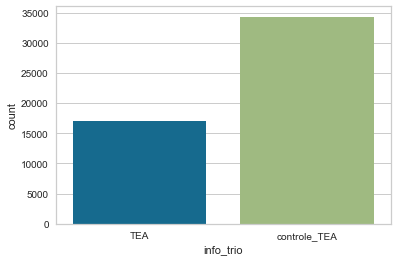

In [11]:
# Plotting the number of individuals with ASD and control individuals (parents of individuals with ASD) on a graph
sns.countplot(sub_TEA_II['info_trio'],label="Count")
plt.show()

In [12]:
# adding up the variant classes by group
sum_group = sub_TEA_II.groupby(['IDS', 'class'])['synonymous SNV','nonsynonymous SNV', 'nonframeshift deletion','frameshift deletion', 'UTR5', 'frameshift insertion', 'nonframeshift insertion', 'downstream', 'exonic;splicing', 'UTR3', 'ncRNA_exonic', 'upstream', 'splicing'].sum()

#setting new index
sum_group.reset_index(level=0, inplace=True)
sum_group.reset_index(level=0, inplace=True)

sum_group =  sum_group[['IDS', 'synonymous SNV', 'nonsynonymous SNV',
       'nonframeshift deletion', 'frameshift deletion', 'UTR5',
       'frameshift insertion', 'nonframeshift insertion', 'downstream',
       'exonic;splicing', 'UTR3', 'ncRNA_exonic', 'upstream', 'splicing', 'class']]
sum_group.head(5)

,IDS,synonymous SNV,nonsynonymous SNV,nonframeshift deletion,frameshift deletion,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing,class
0,FAM16.vcf.7924.,161,197,7,4,0,0,2,1,0,0,1,0,0,0
1,FAM16.vcf.7925.,115,150,6,6,0,1,2,0,0,0,0,0,0,0
2,FAM16.vcf.7926.,153,162,10,4,1,2,0,0,0,0,0,0,0,1
3,FAM17.vcf.7927.,138,190,3,3,0,1,0,0,0,0,0,0,0,0
4,FAM17.vcf.7928.,136,189,6,2,2,2,2,0,0,0,0,0,0,0


In [13]:
#Number of individuals we are analyzing in the ASD subset
len(sum_group['IDS'].unique())

141

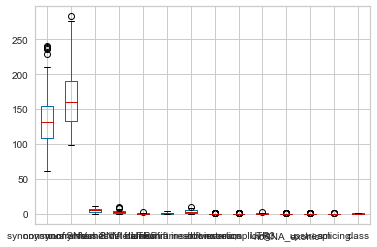

In [14]:
# Plotting the distribution of variants (features).
# By visualization, we realized that it was necessary to normalize the data 
# because they're not all at close ranges.

sum_group.boxplot()

#### Putting the values in an array

In [15]:
#Placing all values in an array 
# where we separate resources and information of labels

array = sum_group.values

list(array)

[array(['FAM16.vcf.7924.', 161, 197, 7, 4, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0],
       dtype=object),
 array(['FAM16.vcf.7925.', 115, 150, 6, 6, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0],
       dtype=object),
 array(['FAM16.vcf.7926.', 153, 162, 10, 4, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1],
       dtype=object),
 array(['FAM17.vcf.7927.', 138, 190, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=object),
 array(['FAM17.vcf.7928.', 136, 189, 6, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
       dtype=object),
 array(['FAM17.vcf.7929.', 141, 212, 6, 3, 1, 1, 3, 1, 0, 0, 0, 0, 0, 1],
       dtype=object),
 array(['FAM20.vcf.7942.', 128, 136, 6, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       dtype=object),
 array(['FAM20.vcf.7943.', 117, 148, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
       dtype=object),
 array(['FAM20.vcf.7944.', 132, 160, 6, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0],
       dtype=object),
 array(['FAM24.vcf.7956.', 205, 236, 8, 5, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1],
       dtype=object),
 array(['FAM24.vcf.7957.', 160, 174, 7,

------------------
#### Normalization

In [16]:
# Normalization
X = array[:,1:14]
Y = array[:,14]
Y=Y.astype('int') 
X_norm = preprocessing.normalize(X, norm='l2')
X_norm

array([[0.63246285, 0.77388312, 0.02749838, ..., 0.00392834, 0.        ,
        0.        ],
       [0.60777691, 0.79275249, 0.0317101 , ..., 0.        , 0.        ,
        0.        ],
       [0.68578844, 0.72612893, 0.04482277, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.58441824, 0.81064466, 0.02356525, ..., 0.        , 0.        ,
        0.        ],
       [0.55347988, 0.83236508, 0.00429054, ..., 0.        , 0.00429054,
        0.        ],
       [0.56837436, 0.82247113, 0.02006027, ..., 0.        , 0.        ,
        0.        ]])

------------------------------------------
#### Plotting a heat map to observe the correlation of features
Correlation indicates how resources are related to each other or to the target variable.

The correlation can be positive (increasing a resource value increases the target variable's value) or negative (increasing a resource value decreases the target variable's value).

The heat map makes it easy to identify which features are most related to the target variable. We will make a heatmap graph of correlated resources using the seaborn library.

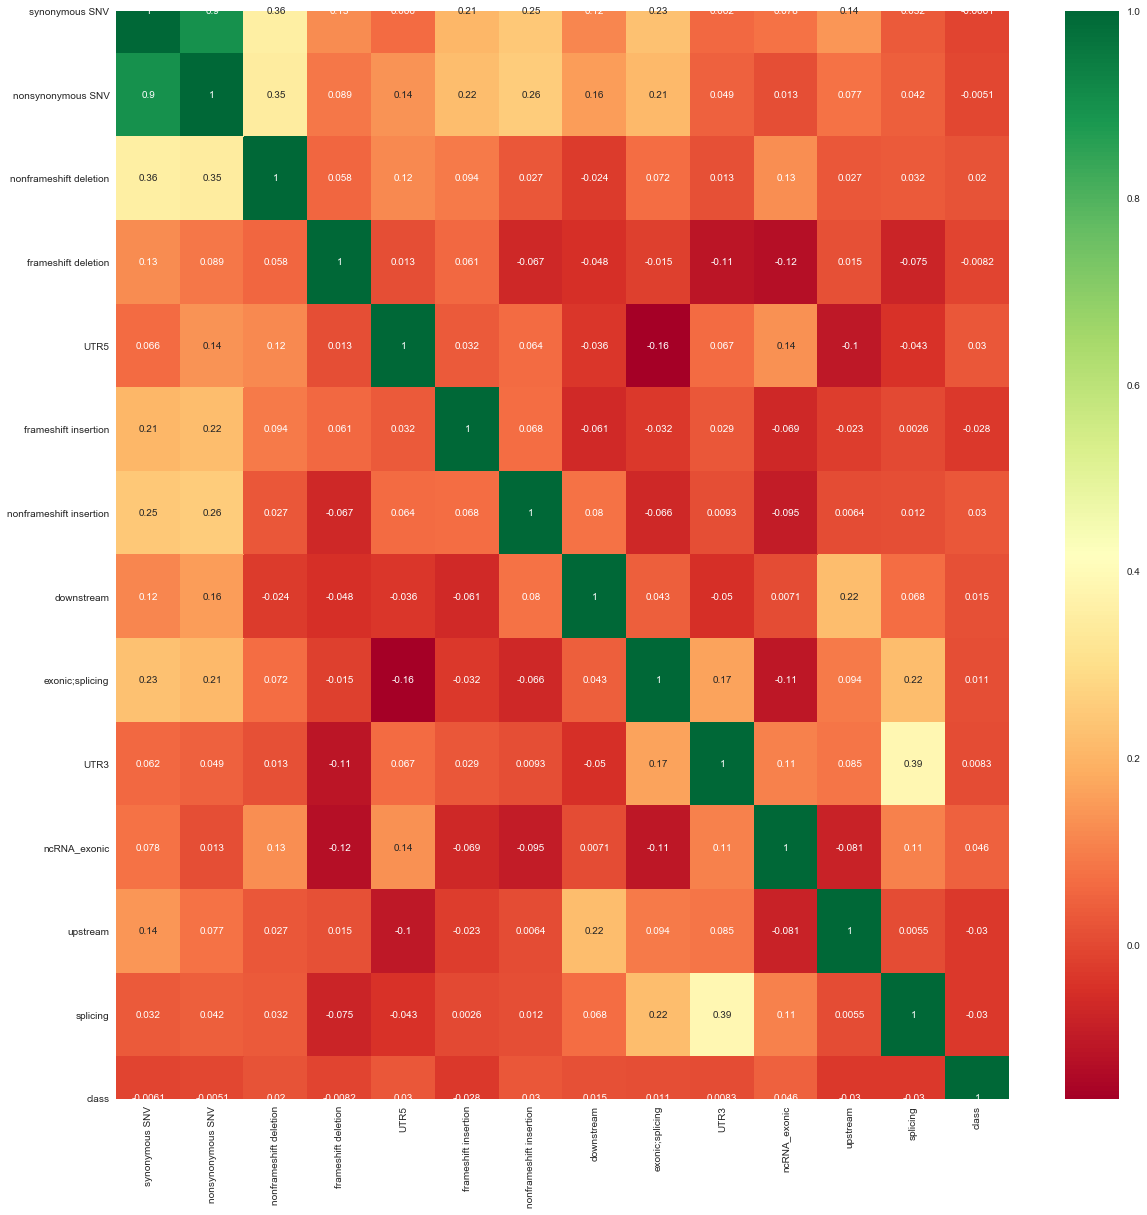

In [17]:
#get correlations of each features in dataset
corrmat = sum_group.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(sum_group[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Feature selection in ASD data <a class="anchor" id="part_02"></a>
#### Using a logistic regression model to score the importance of each feature

In [18]:
# defining the model
model = LogisticRegression(max_iter=10000, solver='liblinear', penalty='l2') # Max iteration number / solver / penalty (l2)

# A regression model that uses the L1 regularization technique is called a Lasso Regression
# and the model that uses L2 is called Ridge Regression.
# The main difference between the two is the penalty period.
# Ridge regression adds “square magnitude” of coefficient as term of
# penalty for the loss function.

# An optimization algorithm is a procedure executed iteratively,
# comparing multiple solutions until an optimal or satisfactory solution is found.

# fit the model
model.fit(X_norm, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# get importance
importance = model.coef_[0]

In [20]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.22416
Feature: 1, Score: -0.28697
Feature: 2, Score: -0.01028
Feature: 3, Score: -0.01626
Feature: 4, Score: 0.00552
Feature: 5, Score: -0.01162
Feature: 6, Score: 0.01360
Feature: 7, Score: 0.00218
Feature: 8, Score: 0.00114
Feature: 9, Score: -0.00288
Feature: 10, Score: 0.00799
Feature: 11, Score: -0.00578
Feature: 12, Score: -0.00177


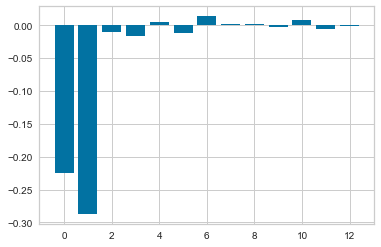

In [21]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Using Random Forest Classifier to assess the importance of features.

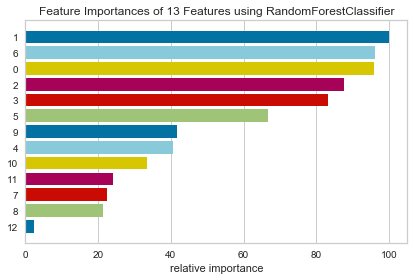

In [22]:
# Defining the model
model = RandomForestClassifier(n_estimators=1000)
#bootstrap default=True

# Plotting feature importances
viz = FeatureImportances(model)
viz.fit(X_norm, Y)
viz.show()

### Creating models to assess training and learning before removing less important features <a class="anchor" id="part_03"></a>

In [23]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.32, random_state=42, shuffle=True,) # 70% training and 30% test
# After splitting, we train the model in the training set and
# we will perform predictions on the test set

#### Random Forest model

In [24]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [25]:
# Checking accuracy using actual and predicted values.

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5652173913043478


Here we observe that the accuracy is around 50%~60%

In [26]:
# Creating auxiliar variables to plot the learning curves
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_norm, Y, cv=5, scoring='accuracy',shuffle = True, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

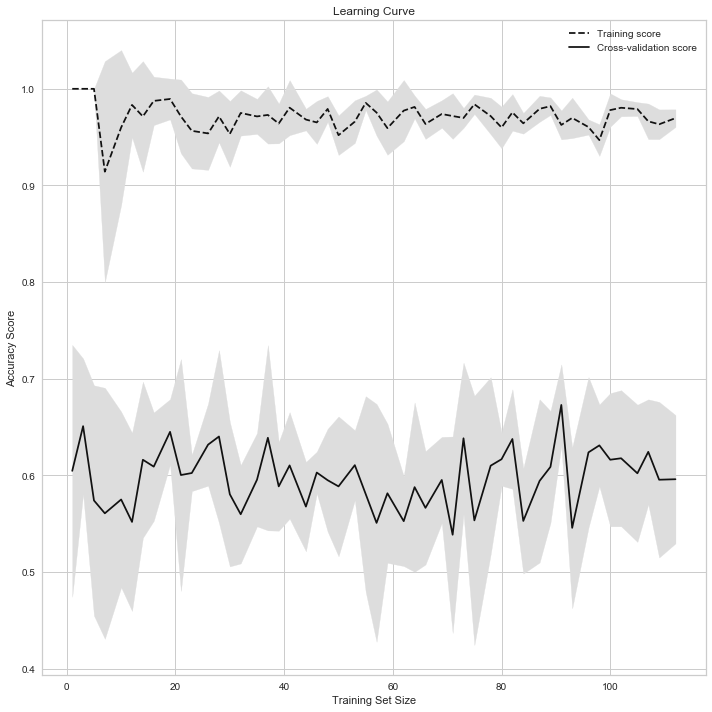

In [27]:
# Calculating the mean and standard deviation of the train and test scores. 

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#----------------------------------------------------

# Plotting
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Creating models to assess training and learning after removing less important features <a class="anchor" id="part_04"></a>

In [28]:
# In this step, 5 features with little importance according to the models used were removed.
del sum_group['splicing']
del sum_group['UTR3']
del sum_group['exonic;splicing']
del sum_group['UTR5']
del sum_group['ncRNA_exonic']

# Updating X and Y
X = array[:,1:9]
Y = array[:,9]
Y=Y.astype('int') 
X_norm = preprocessing.normalize(X, norm='l2')

In [29]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.32, random_state=42, shuffle=True,) # 70% training and 30% test

#### Random Forest model

In [30]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [31]:
# Checking accuracy using actual and predicted values.

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8478260869565217


After removing the less important features, we observe that the accuracy increases and is now around 80%.

In [32]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_norm, Y, cv=5, scoring='accuracy',shuffle = True, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

C:\Users\T-Gamer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


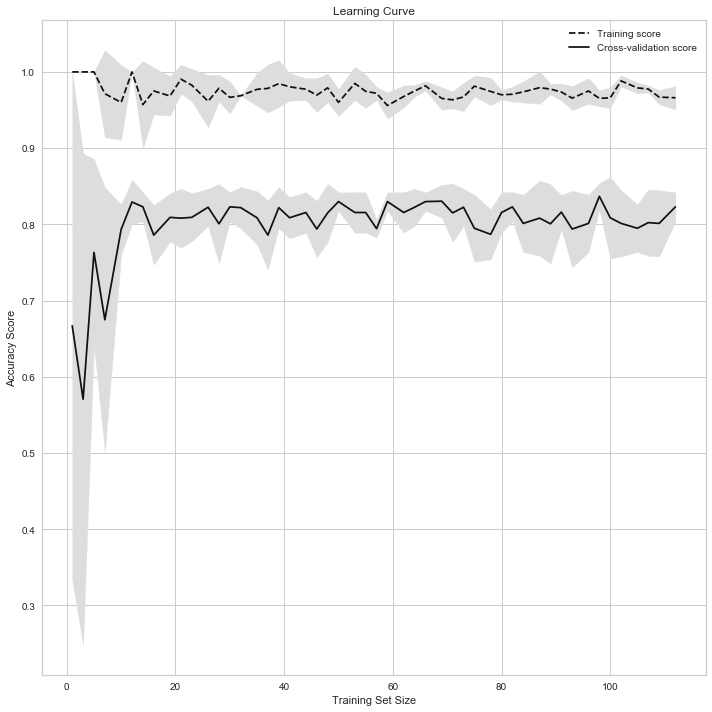

In [33]:
# Calculating the mean and standard deviation of the train and test scores. 

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#----------------------------------------------------
# Plotting
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

------------------
### ADHD data analysis <a class="anchor" id="part_05"></a>

#### Separation of only ADHD data and its controls

In [34]:
sub_TDAH = df[df["info_trio"].isin(['TDAH', 'controle_TDAH'])]
sub_TDAH['class'] = 0
sub_TDAH.head(10) # Vizualization of the first lines

,Unnamed: 0,Chr,Start,End,Ref,Alt,Ref_Gene,Func_refGene,ExonicFunc_refGene,avsnp147_x,...,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing,class
51386,51386,1,914826,914826,G,C,PERM1,exonic,synonymous SNV,rs111310172,...,0,0,0,0,0,0,0,0,0,0
51387,51387,1,1019383,1019383,C,T,C1orf159,exonic,synonymous SNV,rs139896904,...,0,0,0,0,0,0,0,0,0,0
51388,51388,1,1146965,1146965,G,A,TNFRSF4,exonic,synonymous SNV,rs35160621,...,0,0,0,0,0,0,0,0,0,0
51389,51389,1,1263085,1263085,G,A,CPTP,exonic,nonsynonymous SNV,rs150672559,...,0,0,0,0,0,0,0,0,0,0
51390,51390,1,1562548,1562548,A,G,MIB2,exonic,synonymous SNV,rs143944834,...,0,0,0,0,0,0,0,0,0,0
51391,51391,1,3386092,3386092,C,T,ARHGEF16,exonic,synonymous SNV,rs150290426,...,0,0,0,0,0,0,0,0,0,0
51392,51392,1,3416246,3416246,G,A,MEGF6,exonic,synonymous SNV,rs61749291,...,0,0,0,0,0,0,0,0,0,0
51393,51393,1,3432025,3432025,C,T,MEGF6,exonic,nonsynonymous SNV,rs12090611,...,0,0,0,0,0,0,0,0,0,0
51394,51394,1,3544154,3544154,C,T,TPRG1L,exonic,synonymous SNV,rs74048685,...,0,0,0,0,0,0,0,0,0,0
51395,51395,1,3547635,3547635,C,T,WRAP73,exonic,synonymous SNV,rs114827156,...,0,0,0,0,0,0,0,0,0,0


In [35]:
sub_TDAH.loc[sub_TDAH.info_trio == 'TDAH', ['class']] = 1
sub_TDAH.loc[sub_TDAH.info_trio == 'controle_TDAH', ['class']] = 0

In [36]:
# Creating a subset with only the columns of interest
sub_TDAH_II = sub_TDAH[[
 'Ref_Gene',
 'CADD_phred',
 'IDS',
 'info_trio',
 'Frequencies',
'synonymous SNV',
 'nonsynonymous SNV',
 'nonframeshift deletion',
 'frameshift deletion',
 'UTR5',
 'frameshift insertion',
 'nonframeshift insertion',
 'downstream',
 'exonic;splicing',
 'UTR3',
 'ncRNA_exonic',
 'upstream',
 'splicing',
'class']]

In [37]:
# adding up the variant classes by group
sum_group = sub_TDAH_II.groupby(['IDS', 'class'])['synonymous SNV','nonsynonymous SNV', 'nonframeshift deletion','frameshift deletion', 'UTR5', 'frameshift insertion', 'nonframeshift insertion', 'downstream', 'exonic;splicing', 'UTR3', 'ncRNA_exonic', 'upstream', 'splicing'].sum()

#setting new index
sum_group.reset_index(level=0, inplace=True)
sum_group.reset_index(level=0, inplace=True)
sum_group

sum_group =  sum_group[['IDS', 'synonymous SNV', 'nonsynonymous SNV',
       'nonframeshift deletion', 'frameshift deletion', 'UTR5',
       'frameshift insertion', 'nonframeshift insertion', 'downstream',
       'exonic;splicing', 'UTR3', 'ncRNA_exonic', 'upstream', 'splicing', 'class']]
sum_group

,IDS,synonymous SNV,nonsynonymous SNV,nonframeshift deletion,frameshift deletion,UTR5,frameshift insertion,nonframeshift insertion,downstream,exonic;splicing,UTR3,ncRNA_exonic,upstream,splicing,class
0,Ex02_final.vcf.18-50063.,180,235,10,3,0,2,7,0,0,1,0,1,0,1
1,Ex02_final.vcf.18-50064.,151,224,7,6,1,1,6,0,0,0,0,0,0,0
2,Ex02_final.vcf.18-50065.,214,267,13,5,1,2,4,0,0,2,2,0,0,0
3,Ex03_final.vcf.18-50066.,167,220,15,7,1,4,9,0,0,3,0,0,0,1
4,Ex03_final.vcf.18-50067.,190,222,20,5,2,3,7,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,FAM1848_TDAH_intervar.vcf.Sample_1848P.,162,191,0,1,2,1,0,0,0,0,0,0,0,0
97,FAM381_TDAH_intervar.vcf.Sample_381F.,73,80,0,0,1,0,0,0,0,1,0,0,0,0
98,FAM381_TDAH_intervar.vcf.Sample_381F.,73,80,0,0,1,0,0,0,0,1,0,0,0,1
99,FAM381_TDAH_intervar.vcf.Sample_381M.,88,73,0,0,1,0,0,0,0,1,1,0,0,0


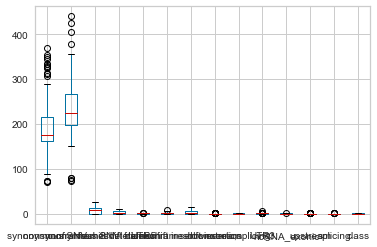

In [38]:
# Plotting the distribution of variants (features).
sum_group.boxplot()

---------------
#### Putting the values in an array

In [39]:
# Placing all values in an array 
# where we separate resources and information of labels
array = sum_group.values 

In [40]:
len(sum_group['IDS'].unique()) #Number of individuals we are analyzing in the ADHD subset

90

---------------
#### Normalization

In [41]:
X = array[:,1:14]
Y = array[:,14]
Y=Y.astype('int') 
X_norm = preprocessing.normalize(X, norm='l2')

In [42]:
X_norm

array([[0.60750863, 0.79313627, 0.03375048, ..., 0.        , 0.00337505,
        0.        ],
       [0.55849367, 0.82849393, 0.02589044, ..., 0.        , 0.        ,
        0.        ],
       [0.62481286, 0.77955623, 0.03795592, ..., 0.00583937, 0.        ,
        0.        ],
       ...,
       [0.67399293, 0.73862239, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76956484, 0.63838901, 0.        , ..., 0.00874505, 0.        ,
        0.        ],
       [0.67747575, 0.73554511, 0.        , ..., 0.        , 0.        ,
        0.        ]])

----------------
#### Plotting a heat map to observe the correlation of features

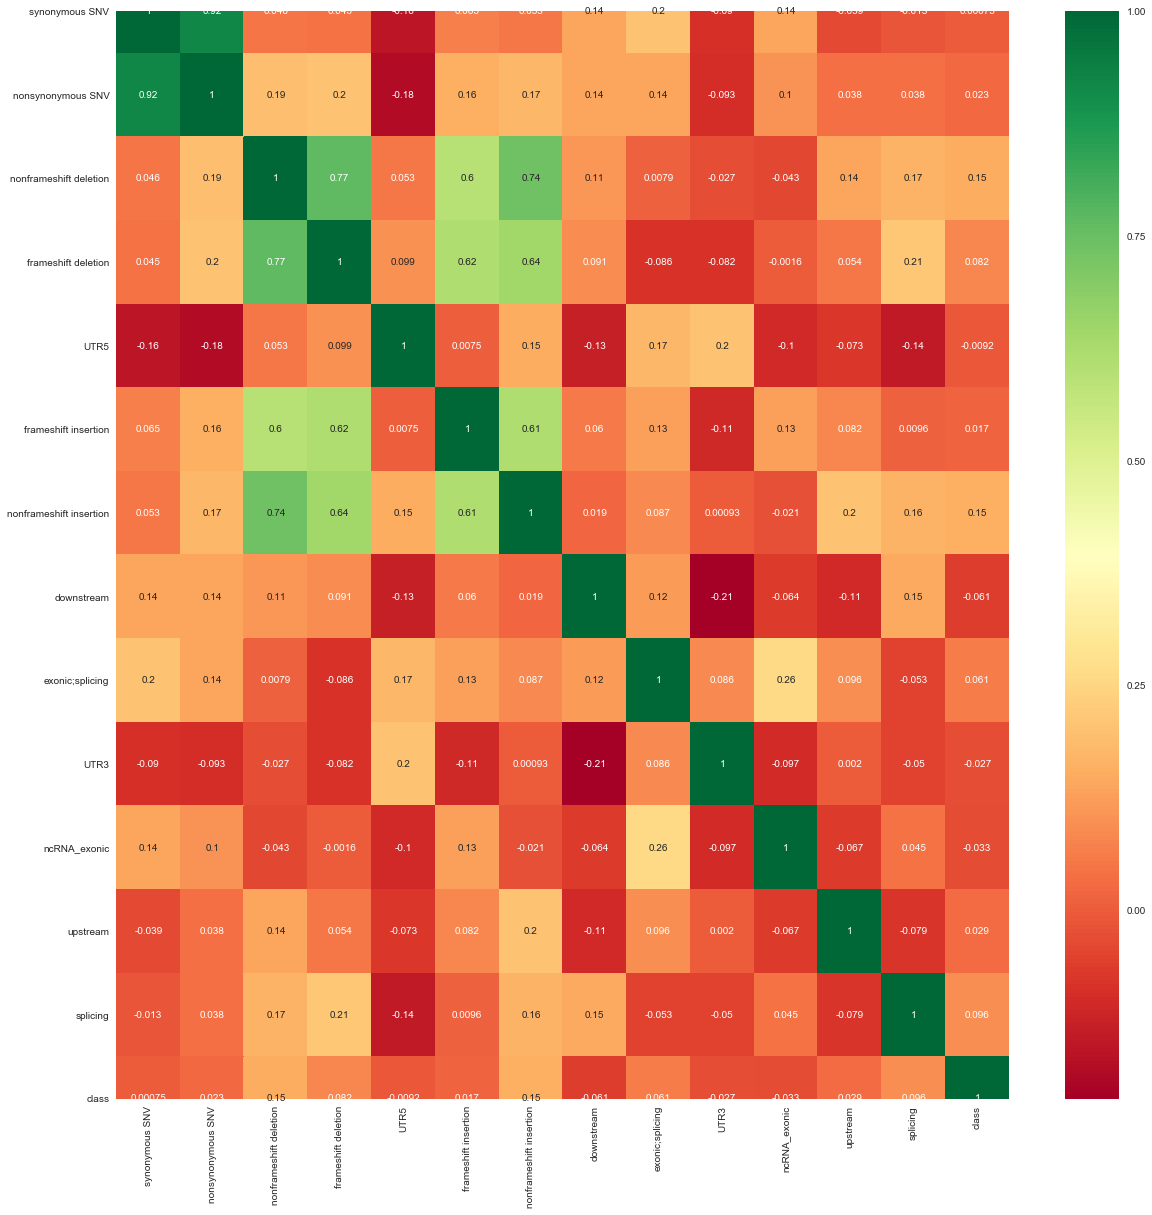

In [43]:
#get correlations of each features in dataset
corrmat = sum_group.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

g=sns.heatmap(sum_group[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Feature selection in ADHD data <a class="anchor" id="part_06"></a>
#### Using a logistic regression model to score the importance of each feature

In [44]:
# defining the model
model = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2') #Número máximo de iterações do algoritmo de otimização.

# fit the model
model.fit(X_norm, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
# get importance
importance = model.coef_[0]

In [46]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.38041
Feature: 1, Score: -0.23457
Feature: 2, Score: 0.16441
Feature: 3, Score: 0.02827
Feature: 4, Score: -0.00039
Feature: 5, Score: -0.00219
Feature: 6, Score: 0.08198
Feature: 7, Score: -0.00352
Feature: 8, Score: 0.00514
Feature: 9, Score: -0.00237
Feature: 10, Score: -0.00740
Feature: 11, Score: 0.00209
Feature: 12, Score: 0.00352


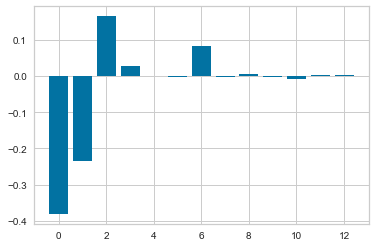

In [47]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#### Using Random Forest Classifier to assess the importance of features.

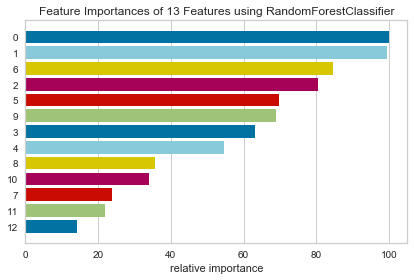

In [48]:
# Defining the model
model = RandomForestClassifier(n_estimators=1000)
#bootstrap default=True

# Plotting feature importances
viz = FeatureImportances(model)
viz.fit(X_norm, Y)
viz.show()

### Creating models to assess training and learning before removing less important features <a class="anchor" id="part_07"></a>

In [49]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.32, random_state=42, shuffle=True,) # 70% training and 30% test
#Após a divisão, treinamos o modelo no conjunto de treinamento e 
#realizaremos previsões no conjunto de teste.

#### Random Forest model

In [50]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [51]:
# Checking accuracy using actual and predicted values.
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.5151515151515151


Here we observe that the accuracy is around 50~60%

In [52]:
# Creating auxiliar variables to plot the learning curves
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_norm, Y, cv=5, scoring='accuracy',shuffle = True, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

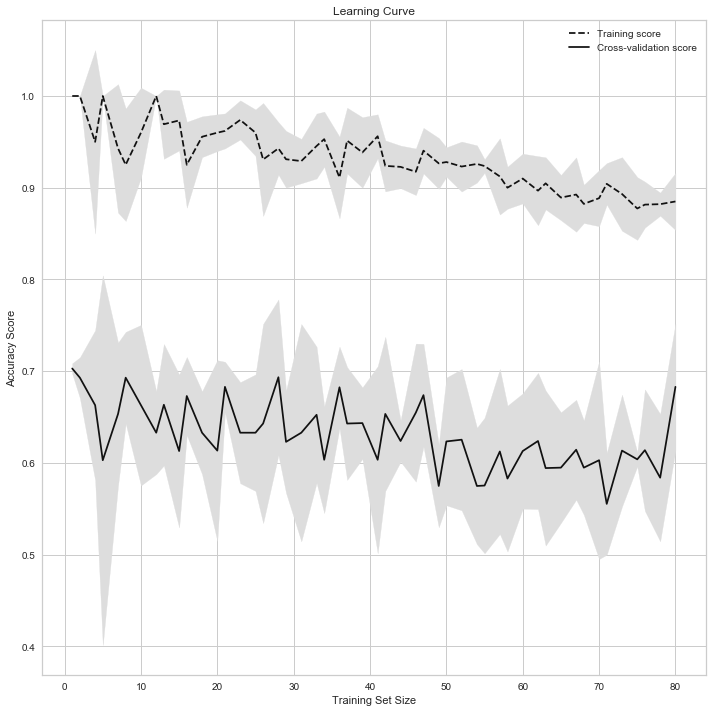

In [53]:
# Calculating the mean and standard deviation of the train and test scores. 

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#----------------------------------------------------

#Plotting
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Creating models to assess training and learning after removing less important features <a class="anchor" id="part_08"></a>

In [54]:
# In this step, 5 features with little importance according to the models used were removed.
del sum_group['splicing']
del sum_group['UTR3']
del sum_group['exonic;splicing']
del sum_group['UTR5']
del sum_group['ncRNA_exonic']

# Updating X and Y
X = array[:,1:9]
Y = array[:,9]
Y=Y.astype('int') 
X_norm = preprocessing.normalize(X, norm='l2')

In [55]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.32, random_state=42, shuffle=True,) # 70% training and 30% test

#### Random Forest model

In [56]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [57]:
# Checking accuracy using actual and predicted values.

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7878787878787878


After removing the less important features we observe that the accuracy increases and is around 80%

In [58]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_norm, Y, cv=5, scoring='accuracy',shuffle = True, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

C:\Users\T-Gamer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


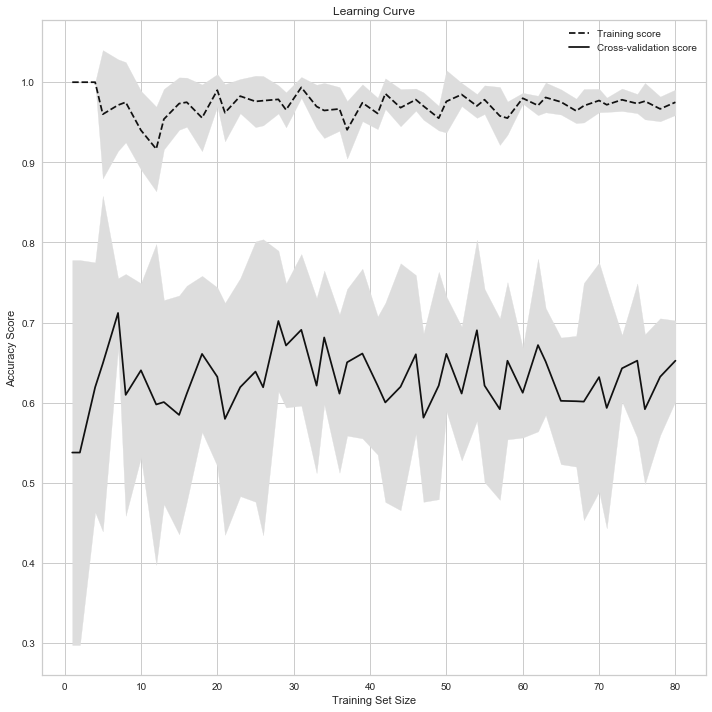

In [59]:
# Calculating the mean and standard deviation of the train and test scores.

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#----------------------------------------------------

# Plotting
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Conclusions <a class="anchor" id="part_09"></a>
It is possible to observe that, with the data of both ASD and ADHD comorbidities, removing the less important features greatly increases the accuracy of the models, from about 50% to 80%, however this accuracy would not be enough to use this classifier in real contexts, as they usually require accuracies higher than 90% or 95%, so possible future interesting researches would be to apply new techniques to these models to assess whether the accuracy would increase even more.